In [1]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

In [2]:
import torch
from torch import nn
from torch.nn.init import calculate_gain
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f'CUDA {i}: {torch.cuda.get_device_name(i)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

CUDA 0: NVIDIA GeForce GTX 1650 Ti


In [3]:
import torch
from torch import nn
from siren_pytorch.siren_pytorch import Modulator, Siren

In [18]:
from models import MLP_PINN
from utils.helpers import cartesian_to_spherical, spherical_to_cartesian
net = MLP_PINN(N_layers=8, width=32, loss_lambda=[1.0, 1.0], activation=nn.Softplus()).to(device)

In [5]:
import os
from utils.dataset import ImplicitDataset, RandomMeshSDFDataset

dataset_name = '../datasets/box_1f0_gyroid_4pi'
output_stl = dataset_name+'.stl'
#train_dataset = ImplicitDataset.from_file(file=dataset_name+'_train.npz', device=device)
train_dataset = RandomMeshSDFDataset(output_stl, sampling_method='importance', device=device)
print(train_dataset)

RandomMeshSDFDataset (10000 points)


In [19]:
from utils.optimizer import CallbackScheduler

# Optimization
## ADA
optimizer=torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
lr_scheduler = CallbackScheduler([
    #CallbackScheduler.reduce_lr(0.2),
    #CallbackScheduler.reduce_lr(0.2),
    #CallbackScheduler.reduce_lr(0.2)
    # CallbackScheduler.init_LBFGS(
    #     lr=1, max_iter=20, max_eval=40, 
    #     tolerance_grad=1e-5, tolerance_change=1e-9,
    #     history_size=100,
    #     line_search_fn=None
    # )
], optimizer=optimizer, model=net, eps=1e-7, patience=300)

In [20]:
max_epochs = 3000
PRINT_EVERY_EPOCH = 100

use_random_sdf = isinstance(train_dataset, RandomMeshSDFDataset)
points = train_dataset.points if use_random_sdf else train_dataset.pde_points
points.requires_grad=True
sdfs = train_dataset.sdfs if use_random_sdf else train_dataset.bc_sdfs
net.loss_lambda[0] = 0.0

try:
    for epoch in range(max_epochs):
        # Training
        optimizer.zero_grad()
        if points.grad is not None:
            points.grad.zero_()
        y = net.forward(points)
        loss = net.loss(y, points, points, sdfs)
        loss.backward()
      
        lr_scheduler.optimizer.step(lambda: loss)
        lr_scheduler.step_when((epoch % 500) == 499)
        lr_scheduler.step_loss(loss)

        if epoch % PRINT_EVERY_EPOCH == 0:
            print(f'#{epoch} Loss: {net._loss_PDE:.6f}, {net._loss_SDF:.6f}')

            # if device.type == 'cuda':
            #     torch.cuda.empty_cache()
        
        # if epoch % 100:
        #     net.loss_lambda[0] = epoch / 2000.0

        if epoch == 1500:
            #extra_points = net.adjust_samples_from_residual(train_dataset.pde_points, num_samples=10000)
            #train_dataset.pde_points = torch.cat((train_dataset.pde_points, extra_points))
            
            net.loss_lambda[0] = 1.0
            print(net.loss_lambda)
        
except KeyboardInterrupt as e:
    print('Bye bye')


#0 Loss: 0.965967, 0.809252
#100 Loss: 0.937031, 0.011350
#200 Loss: 0.970408, 0.011050
#300 Loss: 0.961513, 0.010842
#400 Loss: 0.943451, 0.010495
#500 Loss: 0.895529, 0.009739
#600 Loss: 0.754795, 0.008024
#700 Loss: 0.642164, 0.006710
#800 Loss: 0.484818, 0.005223
#900 Loss: 0.507442, 0.005997
#1000 Loss: 0.402779, 0.004013
#1100 Loss: 0.386733, 0.003774
#1200 Loss: 0.402492, 0.003727
#1300 Loss: 0.379869, 0.003684
#1400 Loss: 0.379264, 0.003676
#1500 Loss: 0.408134, 0.003765
tensor([1., 1.])
#1600 Loss: 0.048005, 0.045377
#1700 Loss: 0.036118, 0.019215
#1800 Loss: 0.013221, 0.019207
#1900 Loss: 0.009521, 0.019683
#2000 Loss: 0.008137, 0.019315
#2100 Loss: 0.006854, 0.019308
#2200 Loss: 0.007789, 0.024120
#2300 Loss: 0.005755, 0.019298
#2400 Loss: 0.005310, 0.019278
#2500 Loss: 0.004906, 0.019275
#2600 Loss: 0.007927, 0.025038
#2700 Loss: 0.004648, 0.019302
#2800 Loss: 0.004292, 0.019250
#2900 Loss: 0.003861, 0.019253


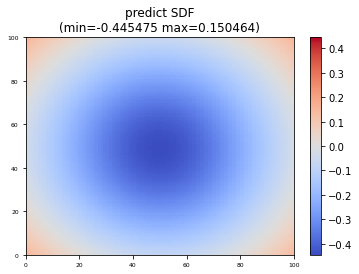

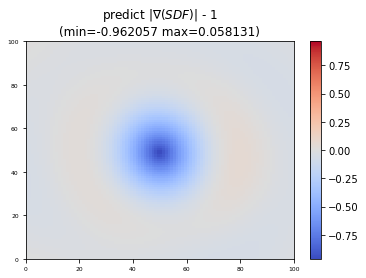

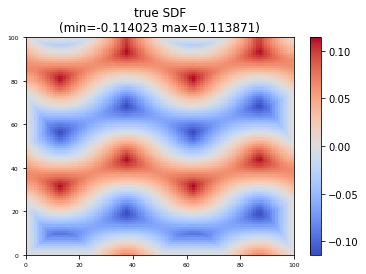

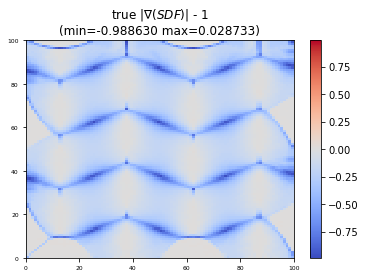

In [21]:
from utils import SDFVisualize, plot_model_weight
visualize = SDFVisualize(z_level=0.1, step=0.05, offset=30, nums=100, device=device)
#visualize.from_nn(net, bounds_from_mesh=output_stl, device=device)
#visualize.from_mesh(output_stl)
visualize.from_dataset(net, dataset_name + '_slice.npz')